In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os



In [2]:
%pip install transformers
%pip install PyPDF2

  Using cached huggingface_hub-0.27.1-py3-none-any.whl.metadata (13 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2024.12.14-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ------------------------ --------------- 6.0/9.7 MB 28.4 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.7 MB 24.5 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 21.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   --

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import pandas as pd
from PyPDF2 import PdfReader
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
# import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\avata\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\avata\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [6]:
resume_data = pd.read_csv('../dataset/Resume.csv')
resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


EDA and Visualizing the Resume Dataset Distribution

In [7]:
resume_data.describe()


,ID
count,2.484000e+03
mean,3.182616e+07
std,2.145735e+07
min,3.547447e+06
25%,1.754430e+07
50%,2.521031e+07
75%,3.611444e+07
max,9.980612e+07


In [8]:
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size and rotation for x-ticks
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)

# Create a count plot
ax = sns.countplot(x="Category", data=resume_data)

# Annotate each bar with its height (the count value)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add gridlines for clarity
plt.title("Resume Counts by Category")
plt.ylabel("Count")
plt.xlabel("Category")

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [10]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# Get category counts and labels
targetCounts = resume_data['Category'].value_counts()
targetLabels = targetCounts.index  # Ensures labels align with counts

# Create a figure
plt.figure(1, figsize=(22, 22))
the_grid = GridSpec(2, 2)

# Generate a colormap
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i / len(targetCounts)) for i in range(len(targetCounts))]

# Plot the pie chart
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140)

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [11]:
resume_data = resume_data.drop(["Resume_html"], axis=1)
resume_data.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


Functions for processing the resumes from the pdf files and preprocessing

In [12]:
from PyPDF2 import PdfReader 

In [23]:
import fitz  # PyMuPDF

def extract_text_from_pdf2(file_path):
    doc = fitz.open(file_path)
    text = "".join(page.get_text() for page in doc)
    doc.close()  # Critical for memory management
    return text

In [14]:
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        if any(criteria in sent for criteria in ['skills', 'education']):
            words = word_tokenize(sent)
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)
    return features

In [22]:
def process_resume_data(df):
    id = df['ID']
    category = df['Category']
    text = extract_text_from_pdf2(f"../dataset/data/{category}/{id}.pdf")
    features = preprocess_text(text)
    df['Feature'] = features['feature']
    return df

In [17]:
def get_embeddings(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().to("cpu").numpy()
    return embeddings

In [18]:
def print_top_matching_resumes(result_group):
    for i in range(15):
        print("\nJob ID:", i)
        print("Cosine Similarity | Domain Resume | Domain Description")
        print(result_group.get_group(i)[['similarity', 'domainResume', 'domainDesc']])

Preprocessing the resume data

In [19]:
#Identify Duplicates in the Dataset
resume_data.duplicated(subset=['Resume_str']).value_counts()

False    2482
True        2
Name: count, dtype: int64

In [24]:
#remove the duplicates from the dataset
resume_data = resume_data.drop_duplicates(subset=['Resume_str'], keep='first')
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2482 entries, 0 to 2482
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2482 non-null   int64 
 1   Resume_str  2482 non-null   object
 2   Category    2482 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


In [18]:
# resume_data = resume_data.apply(process_resume_data, axis=1)
# resume_data.head()

In [25]:
resume_data = resume_data.apply(process_resume_data, axis=1)
resume_data.head()

,ID,Resume_str,Category,Feature
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist hr operations summary media prof...
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary years experience recruitin...
3,27018550,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


In [27]:
resume_data['Feature'][0]

'hr administrator marketing associate hr administrator summary dedicated customer service manager years experience hospitality customer service management respected builder leader customer focused teams strives instill shared enthusiastic commitment customer service highlights focused customer satisfaction team management marketing savvy conflict resolution techniques training development skilled multi tasker client relations specialist accomplishments missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton general manager training certification accomplished trainer cross server hospitality systems hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses seminars customer service sales strategies inventory control loss prevention safety time management leadership performance assessment experience hr administrator marketing associate hr administrator dec current company name city state helps develop policie

In [28]:
resume_data = resume_data.drop(columns=['Resume_str'])
resume_data.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [29]:
import nltk
from nltk.probability import FreqDist

# Get the most common words
def print_most_frequent_words(text, top_n=50):
    words = nltk.word_tokenize(text)
    wordfreqdist = FreqDist(words)
    mostcommon = wordfreqdist.most_common(top_n)
    for word, freq in mostcommon:
        print(f"{word}: {freq}")

combined_text = " ".join(resume_data['Feature'].astype(str))
print_most_frequent_words(combined_text)

state: 16152
company: 15204
city: 15064
management: 12173
name: 11731
sales: 8258
customer: 7918
business: 7863
skills: 7721
new: 6402
service: 6197
team: 6064
development: 5734
training: 5629
experience: 5613
project: 5365
work: 4797
manager: 4534
information: 4499
marketing: 4491
financial: 4214
office: 4178
support: 4123
education: 4090
including: 4044
staff: 3918
professional: 3854
data: 3787
system: 3695
systems: 3556
university: 3475
managed: 3435
process: 3418
customers: 3386
design: 3384
quality: 3353
client: 3271
clients: 3239
developed: 3231
reports: 3086
analysis: 3041
operations: 3003
high: 2950
product: 2946
program: 2934
services: 2835
accounting: 2831
microsoft: 2828
current: 2786
accounts: 2776


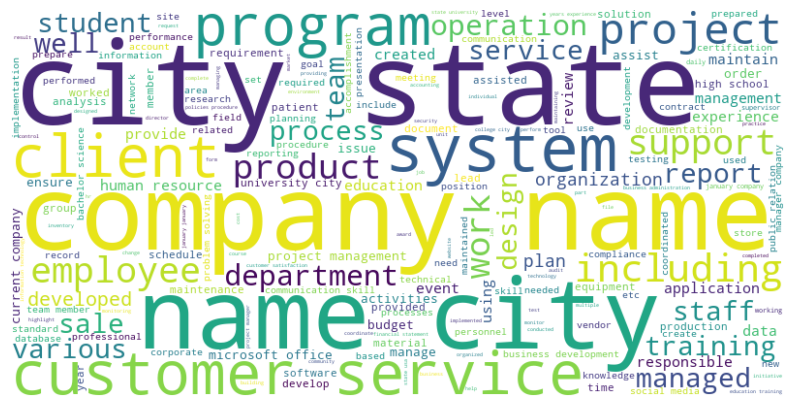

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Preprocessing the company_industries (used to filter out job descriptions from matching industries that validate our resume data)

In [31]:
company_industries = pd.read_csv("../dataset/job_listings/companies/company_industries.csv")

company_industries.head()

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


In [32]:
company_industries['industry'].value_counts()

industry
Staffing and Recruiting           2387
IT Services and IT Consulting     2130
Hospitals and Health Care         1673
Software Development              1440
Financial Services                 986
                                  ... 
Warehousing and Storage              2
Mobile Gaming Apps                   1
Wireless Services                    1
Strategic Management Services        1
Alternative Dispute Resolution       1
Name: count, Length: 144, dtype: int64

In [33]:
company_industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24375 entries, 0 to 24374
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company_id  24375 non-null  int64 
 1   industry    24375 non-null  object
dtypes: int64(1), object(1)
memory usage: 381.0+ KB


In [35]:
desired_industries = ["IT Services and IT Consulting", "Financial Services", "Real Estate", "Banking" , "Software Development"]



Processing of Job Descriptions takes longer time, so we will choose a smaller subset of JDs to carry on with out experiment.

To optimize the output of our results, we will use Company_industries table to filter out JDs to keep only a few industries that we will test our code on (also after looking at which industries we readily have in our resume_dataset)


In [36]:
filtered_industries = company_industries[company_industries['industry'].isin(desired_industries)]
filtered_industries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5321 entries, 2 to 24371
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company_id  5321 non-null   int64 
 1   industry    5321 non-null   object
dtypes: int64(1), object(1)
memory usage: 124.7+ KB


In [37]:
filtered_industries.head()

,company_id,industry
2,20300,Banking
5,729238,IT Services and IT Consulting
8,2934678,IT Services and IT Consulting
9,15984730,IT Services and IT Consulting
10,34771607,Financial Services


Preprocessing Job Postings Dataset (Linkedin)

In [38]:
job_posts = pd.read_csv('../dataset/postings.csv')
job_posts.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [40]:
job_posts = job_posts[["job_id","company_id","company_name","title","description","skills_desc"]]
job_posts.head()

,job_id,company_id,company_name,title,description,skills_desc
0,921716,2774458.0,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...
1,1829192,NaN,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",NaN
2,10998357,64896719.0,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...
3,23221523,766262.0,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...
4,35982263,NaN,NaN,Service Technician,Looking for HVAC service tech with experience ...,NaN


In [39]:
print(job_posts["skills_desc"][12])

Skills/Qualifications: Two-year or four-year degree in business or marketing and 0—2 years of previous experience. Position requires outstanding verbal skills and the ability to handle multiple tasks. Must be proficient in Microsoft Word, Outlook, Excel, Power Point, and Constant Contact. Social media knowledge and some graphic design skills would be a definite advantage. 


In [40]:
job_descriptions = job_posts[["description","skills_desc","title","company_id"]]
job_descriptions.head()

,description,skills_desc,title,company_id
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0
1,"At Aspen Therapy and Wellness , we are committ...",NaN,Mental Health Therapist/Counselor,NaN
2,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,Assitant Restaurant Manager,64896719.0
3,Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,Senior Elder Law / Trusts and Estates Associat...,766262.0
4,Looking for HVAC service tech with experience ...,NaN,Service Technician,NaN


In [41]:
job_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  123842 non-null  object 
 1   skills_desc  2439 non-null    object 
 2   title        123849 non-null  object 
 3   company_id   122132 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.8+ MB


In [42]:
job_descriptions.isnull().sum()

description         7
skills_desc    121410
title               0
company_id       1717
dtype: int64

In [43]:
job_descriptions = job_descriptions.dropna()
job_descriptions.isnull().sum()

description    0
skills_desc    0
title          0
company_id     0
dtype: int64

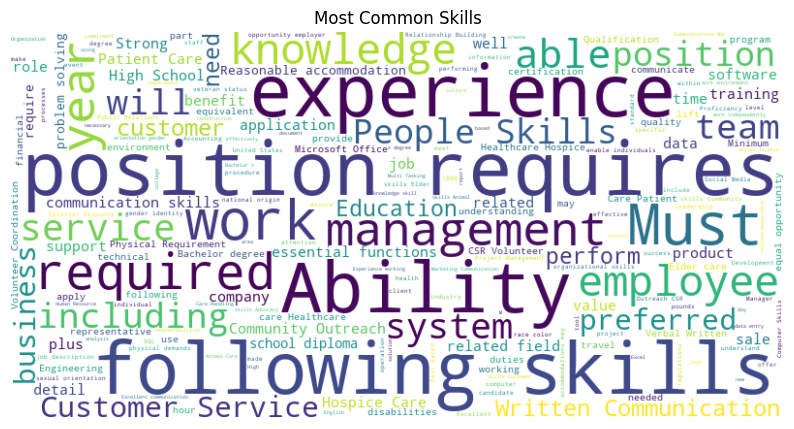

In [44]:
from wordcloud import WordCloud

# Combine all skills into a single string
all_skills = " ".join(job_descriptions['skills_desc'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_skills)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills')
plt.show()

C:\Users\avata\AppData\Local\Temp\ipykernel_54760\487409209.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


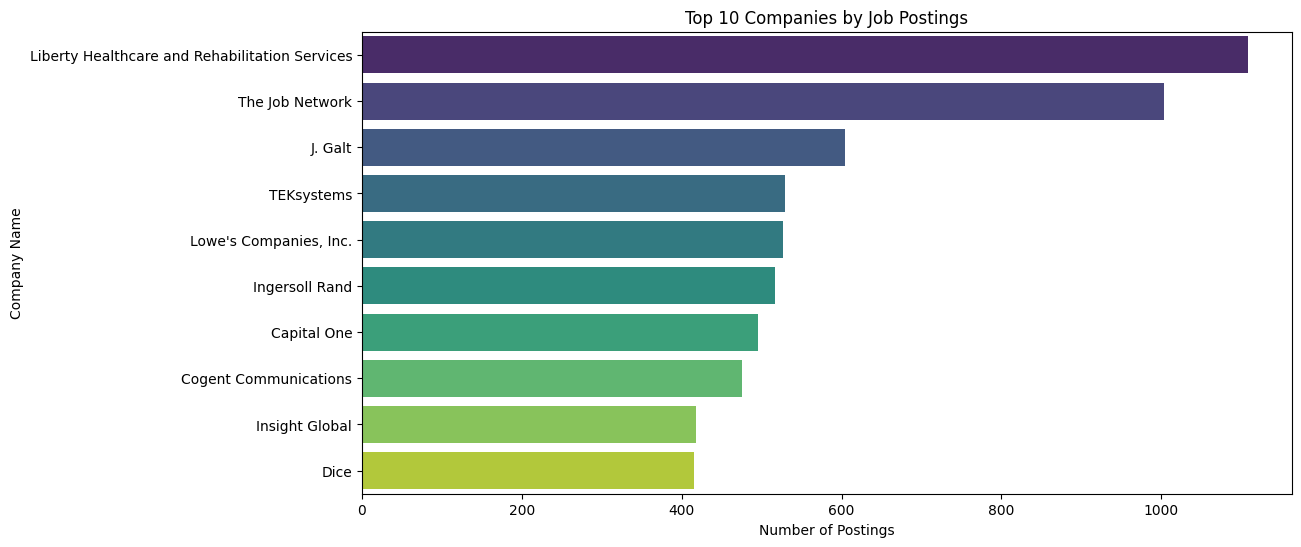

In [49]:
import seaborn as sns
# Countplot for top 10 most frequent companies
plt.figure(figsize=(12, 6))
sns.countplot(
    y='company_name',
    data=job_posts,
    order=job_posts['company_name'].value_counts().index[:10],
    palette='viridis'
)
plt.title('Top 10 Companies by Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Company Name')
plt.show()

In [50]:
job_descriptions_filtered = job_descriptions.merge(filtered_industries[['company_id']], on='company_id', how='inner')

In [54]:
job_descriptions.columns

Index(['description', 'skills_desc', 'title', 'company_id'], dtype='object')

In [55]:
filtered_industries.columns

Index(['company_id', 'industry'], dtype='object')

In [56]:
job_descriptions_filtered.columns

Index(['description', 'skills_desc', 'title', 'company_id'], dtype='object')

In [51]:
job_descriptions_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  434 non-null    object 
 1   skills_desc  434 non-null    object 
 2   title        434 non-null    object 
 3   company_id   434 non-null    float64
dtypes: float64(1), object(3)
memory usage: 13.7+ KB


In [52]:
job_descriptions_filtered.head()

,description,skills_desc,title,company_id
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Strong interpersonal communication skills and ...,Controller,988555.0
2,Software Tester - State Government or Public S...,"SYSTEM TESTING , MICROSOFT OFFICE , SOFTWARE D...",Software Tester,95750606.0
3,About the Role:\n\nAs a CBRE Legal Data Analys...,What You’ll Need: \n\n * Applicants must be cu...,Legal Data Analyst (Dallas/Chicago),2319.0
4,Description:\nAvesta Housing is seeking a hard...,Ability to meet facility and state immunizatio...,Cook,1182899.0


In [57]:
job_descriptions2 = job_descriptions_filtered.dropna()
job_descriptions2.head()
job_descriptions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  434 non-null    object 
 1   skills_desc  434 non-null    object 
 2   title        434 non-null    object 
 3   company_id   434 non-null    float64
dtypes: float64(1), object(3)
memory usage: 13.7+ KB


In [58]:
print(job_descriptions2['description'].apply(type).value_counts())

description
<class 'str'>    434
Name: count, dtype: int64


In [60]:
job_descriptions2.shape

(434, 4)

In [59]:
# Drop rows where 'description' is not a string
job_descriptions2 = job_descriptions2[job_descriptions2['description'].apply(lambda x: isinstance(x, str))]

In [61]:
#tweaked for JDs
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        # Tokenize, remove stopwords, and filter by POS tags
        words = word_tokenize(sent)
        words = [word for word in words if word not in stop_words]
        tagged_words = pos_tag(words)
        filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
        features['feature'] += " ".join(filtered_words) + " "
    return features

In [62]:
job_descriptions2['jdFeatures'] = job_descriptions2['description'].apply(lambda x : preprocess_text(x)['feature'])
job_descriptions2['skillFeatures'] = job_descriptions2['skills_desc'].apply(lambda x : preprocess_text(x)['feature'])
job_descriptions2.head()

,description,skills_desc,title,company_id,jdFeatures,skillFeatures
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0,job descriptiona leading real estate firm new ...,
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Strong interpersonal communication skills and ...,Controller,988555.0,work swshannon waltchack sw seeking commercial...,strong interpersonal communication skills stro...
2,Software Tester - State Government or Public S...,"SYSTEM TESTING , MICROSOFT OFFICE , SOFTWARE D...",Software Tester,95750606.0,,
3,About the Role:\n\nAs a CBRE Legal Data Analys...,What You’ll Need: \n\n * Applicants must be cu...,Legal Data Analyst (Dallas/Chicago),2319.0,,need applicants must currently authorized work...
4,Description:\nAvesta Housing is seeking a hard...,Ability to meet facility and state immunizatio...,Cook,1182899.0,description avesta housing seeking hard workin...,ability meet facility state immunization requi...


In [63]:
#Replacing empty string with Null
job_descriptions2['jdFeatures'] = job_descriptions2['jdFeatures'].replace(r'^\s*$', np.nan, regex=True)
job_descriptions2['skillFeatures'] = job_descriptions2['skillFeatures'].replace(r'^\s*$', np.nan, regex=True)
job_descriptions2.head()

,description,skills_desc,title,company_id,jdFeatures,skillFeatures
0,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,Marketing Coordinator,2774458.0,job descriptiona leading real estate firm new ...,NaN
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Strong interpersonal communication skills and ...,Controller,988555.0,work swshannon waltchack sw seeking commercial...,strong interpersonal communication skills stro...
2,Software Tester - State Government or Public S...,"SYSTEM TESTING , MICROSOFT OFFICE , SOFTWARE D...",Software Tester,95750606.0,NaN,NaN
3,About the Role:\n\nAs a CBRE Legal Data Analys...,What You’ll Need: \n\n * Applicants must be cu...,Legal Data Analyst (Dallas/Chicago),2319.0,NaN,need applicants must currently authorized work...
4,Description:\nAvesta Housing is seeking a hard...,Ability to meet facility and state immunizatio...,Cook,1182899.0,description avesta housing seeking hard workin...,ability meet facility state immunization requi...


In [64]:
job_descriptions2.isnull().sum()

description        0
skills_desc        0
title              0
company_id         0
jdFeatures       119
skillFeatures    406
dtype: int64

In [65]:
job_descriptions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   description    434 non-null    object 
 1   skills_desc    434 non-null    object 
 2   title          434 non-null    object 
 3   company_id     434 non-null    float64
 4   jdFeatures     315 non-null    object 
 5   skillFeatures  28 non-null     object 
dtypes: float64(1), object(5)
memory usage: 20.5+ KB


In [66]:
job_descriptions2 = job_descriptions2.drop(columns=["skills_desc","skillFeatures"],axis=1)
job_descriptions2.head()

,description,title,company_id,jdFeatures
0,Job descriptionA leading real estate firm in N...,Marketing Coordinator,2774458.0,job descriptiona leading real estate firm new ...
1,WORK @ SWShannon Waltchack (SW) is seeking a C...,Controller,988555.0,work swshannon waltchack sw seeking commercial...
2,Software Tester - State Government or Public S...,Software Tester,95750606.0,NaN
3,About the Role:\n\nAs a CBRE Legal Data Analys...,Legal Data Analyst (Dallas/Chicago),2319.0,NaN
4,Description:\nAvesta Housing is seeking a hard...,Cook,1182899.0,description avesta housing seeking hard workin...


In [67]:
job_descriptions2 = job_descriptions2.dropna(subset=['jdFeatures'])
job_descriptions2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 433
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  315 non-null    object 
 1   title        315 non-null    object 
 2   company_id   315 non-null    float64
 3   jdFeatures   315 non-null    object 
dtypes: float64(1), object(3)
memory usage: 12.3+ KB


Part 2: Matching Resumes with JDs

Approach 1: TF-IDF Vectorization and then finding similarity

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all text data for fitting the vectorizer
corpus = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])

# Initialize and fit TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(corpus)

# Split the TF-IDF matrix into resumes and job descriptions
resume_tfidf = tfidf_matrix[:len(resume_data)]
job_tfidf = tfidf_matrix[len(resume_data):]

In [69]:
print(resume_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 750660 stored elements and shape (2482, 5000)>
  Coords	Values
  (0, 2135)	0.1200970553108952
  (0, 129)	0.12475247709107636
  (0, 2717)	0.25863186088652323
  (0, 339)	0.06217557941939533
  (0, 4469)	0.012664464254828148
  (0, 1191)	0.02855403130285828
  (0, 1104)	0.1781794669142717
  (0, 4099)	0.12051382296605974
  (0, 2676)	0.05908562455158506
  (0, 4992)	0.015739189929846582
  (0, 1687)	0.019211907777480906
  (0, 2119)	0.07921934576584184
  (0, 2644)	0.06639301570047586
  (0, 528)	0.04362782216587325
  (0, 2482)	0.02483067283418023
  (0, 1855)	0.051417221313509565
  (0, 4563)	0.02248259540203415
  (0, 4137)	0.03853011780475021
  (0, 1568)	0.034727961521175126
  (0, 796)	0.03756350468745321
  (0, 2086)	0.017984807869882415
  (0, 3992)	0.02475966471271838
  (0, 4550)	0.012121218939406616
  (0, 3997)	0.040633192425019164
  (0, 907)	0.03315498211280172
  :	:
  (2481, 392)	0.034922358737996165
  (2481, 1271)	0.0449013302584240

Similarity Measurement - Using Cosine Similarity to match resumes with job descriptions¶

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_similarity_matrix = cosine_similarity(job_tfidf, resume_tfidf)

# Get top 5 resumes for each job description
for job_idx in range(5,15):
    top_resumes = tfidf_similarity_matrix[job_idx].argsort()[::-1][:5]
    print(f"Job: {job_descriptions2['title'].iloc[job_idx]}")
    for idx in top_resumes:
        print(f"  Resume ID: {resume_data['ID'].iloc[idx]}, Similarity: {tfidf_similarity_matrix[job_idx][idx]:.4f}")

Job: Oracle HCM Cloud Architect
  Resume ID: 21366189, Similarity: 0.3626
  Resume ID: 93349646, Similarity: 0.3468
  Resume ID: 13454871, Similarity: 0.2938
  Resume ID: 18159866, Similarity: 0.2767
  Resume ID: 33381211, Similarity: 0.2544
Job: SAP ISU ABAP, CDS view, AMDP, C4C
  Resume ID: 93459677, Similarity: 0.2300
  Resume ID: 56068028, Similarity: 0.1719
  Resume ID: 38535335, Similarity: 0.1607
  Resume ID: 23527321, Similarity: 0.1578
  Resume ID: 22259768, Similarity: 0.1521
Job: AS400 Developer
  Resume ID: 99124477, Similarity: 0.2694
  Resume ID: 13520837, Similarity: 0.2496
  Resume ID: 18297650, Similarity: 0.2055
  Resume ID: 85101052, Similarity: 0.1620
  Resume ID: 19053815, Similarity: 0.1368
Job: Windows Architect
  Resume ID: 27058381, Similarity: 0.4378
  Resume ID: 15145575, Similarity: 0.4147
  Resume ID: 12043694, Similarity: 0.3563
  Resume ID: 10089434, Similarity: 0.3463
  Resume ID: 33627938, Similarity: 0.3418
Job: Developer
  Resume ID: 28505854, Similar

Take Custom Resume


In [72]:
custom_resume = extract_text_from_pdf2('../dataset/data/INFORMATION-TECHNOLOGY/10089434.pdf')
features = preprocess_text(custom_resume)
custom_resume_features = features['feature']
print(custom_resume_features)

information technology technician summary versatile systems administrator possessing superior troubleshooting skills networking issues end user problems network security experienced server management systems analysis offering depth understanding infrastructure areas detail oriented independent focused taking systematic approach solving complex problems demonstrated exceptional technical knowledge skills working various teams achieve shared goals objectives highlights active directory group policy objects powershell vbscript microsoft exchange vmware experience new technology product research office azure storage management enterprise backup management disaster recovery experience information technology technician aug current company name city state migrating managing user accounts microsoft office exchange online creating managing virtual machines systems domain controllers active directory federation services adfs microsoft windows azure iaas creating managing storage microsoft window

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 0 stored elements and shape (2482, 5000)>


In [64]:
check_orig_resume = pd.read_csv('../dataset/Resume.csv')
check_orig_resume.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [65]:
print("Job: Engineering Project Manager | Similarity: 0.3897")
resume_row = check_orig_resume[check_orig_resume['ID'] == 28697203]
print()
print(resume_row['Resume_str'].iloc[0])

Job: Engineering Project Manager | Similarity: 0.3897

        AS         INFORMATION TECHNOLOGY PROJECT MANAGER       Summary    SUMMARY Skilled IT professional with 7 years of proven success in developing and leading cross-functional
technical teams to execute and deliver major technology initiatives using the Agile methodology and
Scaled Agile Framework (SAFe). Well-versed in managing projects with co-located and off-site teams.
Expertise in gathering and translating requirements, leading scrum teams, and release management,
including owning the release management lifecycle for multiple applications across different
environments.      Skills          Agile methodology  Project management  SAFe Program Increment (PI) Planning  Scrum / Kanban / Scrumban  Aptitude for resolving challenging problems  Client relations  Team building  Release management  Scrum master / Business analyst  Atlassian suite (JIRA, Confluence, Trello)  Public Trust Clearance Level 4  Agile  Approach      Budget

In [66]:
resume_row

,ID,Resume_str,Resume_html,Category
268,28697203,AS INFORMATION TECHNOLOGY PROJ...,"<div class=""RNA skn-mng3 fontsize fontface vma...",INFORMATION-TECHNOLOGY


Approach 2: Topic Modeling (LDA) to extract topics from resumes and job descriptions

In [67]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
all_text = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])
vectorized_text = vectorizer.fit_transform(all_text)

# Step 2: Fit LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Assuming 3 topics for simplicity
lda_matrix = lda.fit_transform(vectorized_text)

# Step 3: Separate LDA outputs for resumes and job descriptions
resume_topics = lda_matrix[:len(resume_data)]
job_topics = lda_matrix[len(resume_data):]

# Step 4: Compute cosine similarity
lda_similarity_matrix = cosine_similarity(job_topics, resume_topics)

# Step 5: Find top matches for each job description
top_matches = {}
for job_idx in range(5,15):
    top_resumes = lda_similarity_matrix[job_idx].argsort()[::-1][:5]  # Top 5 matches
    top_matches[job_descriptions2['title'].iloc[job_idx]] = [
        (resume_data['ID'].iloc[resume_idx], lda_similarity_matrix[job_idx, resume_idx])
        for resume_idx in top_resumes
    ]

# Display the results
for job, matches in top_matches.items():
    print(f"Job Title: {job}")
    for resume_id, score in matches:
        print(f"  Resume ID: {resume_id}, Similarity Score: {score:.4f}")

Job Title: Oracle HCM Cloud Architect
  Resume ID: 17983957, Similarity Score: 0.9937
  Resume ID: 28126340, Similarity Score: 0.9876
  Resume ID: 36856210, Similarity Score: 0.9855
  Resume ID: 26341987, Similarity Score: 0.9848
  Resume ID: 38753827, Similarity Score: 0.9752
Job Title: SAP ISU ABAP, CDS view, AMDP, C4C
  Resume ID: 19161572, Similarity Score: 0.9981
  Resume ID: 22351830, Similarity Score: 0.9980
  Resume ID: 12415691, Similarity Score: 0.9901
  Resume ID: 20674668, Similarity Score: 0.9768
  Resume ID: 62994611, Similarity Score: 0.9708
Job Title: AS400 Developer
  Resume ID: 81761658, Similarity Score: 0.9918
  Resume ID: 11957080, Similarity Score: 0.9528
  Resume ID: 18301617, Similarity Score: 0.9523
  Resume ID: 22450718, Similarity Score: 0.9464
  Resume ID: 51432451, Similarity Score: 0.9451
Job Title: Windows Architect
  Resume ID: 28790806, Similarity Score: 0.9998
  Resume ID: 63989974, Similarity Score: 0.9995
  Resume ID: 22890839, Similarity Score: 0.99

In [85]:
job_descriptions2.columns

Index(['description', 'title', 'company_id', 'jdFeatures', 'similarity_score'], dtype='object')

In [86]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
all_text = list(resume_data['Feature']) + list(job_descriptions2['jdFeatures'])
vectorized_text = vectorizer.fit_transform(all_text)

# Step 2: Fit LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Assuming 10 topics
lda_matrix = lda.fit_transform(vectorized_text)

# Step 3: Separate LDA outputs for resumes and job descriptions
resume_topics = lda_matrix[:len(resume_data)]
job_topics = lda_matrix[len(resume_data):]

# Step 4: Compute cosine similarity between a resume and job descriptions
def find_similar_jobs_for_resume(resume_idx, resume_topics, job_topics, job_descriptions2, top_n=5):
    # Get the topic distribution for the specified resume
    resume_topic_distribution = resume_topics[resume_idx].reshape(1, -1)
    
    # Compute cosine similarity between the resume and all job descriptions
    similarity_scores = cosine_similarity(resume_topic_distribution, job_topics).flatten()
    
    # Add similarity scores to the job descriptions dataframe
    job_descriptions2['similarity_score'] = similarity_scores
    
    # Sort jobs by similarity score and get top matches
    top_jobs = job_descriptions2.sort_values(by='similarity_score', ascending=False).head(top_n)
    return top_jobs

# Step 5: Example usage
# Choose a resume index (e.g., the first resume)
resume_idx = 0  # Replace with the index of the resume you want to analyze
top_jobs = find_similar_jobs_for_resume(resume_idx, resume_topics, job_topics, job_descriptions2, top_n=5)

# Step 6: Display the results
print(f"Top jobs for Resume ID: {resume_data['ID'].iloc[resume_idx]}")
print(top_jobs[['title', 'similarity_score']])  # Use 'title' for job titles

Top jobs for Resume ID: 16852973
                                                 title  similarity_score
283  Senior Manager, Channel Programs and Enablemen...          0.910699
282  Senior Manager, Channel Programs and Enablemen...          0.910699
393                       Bi-Lingual Intake Specialist          0.889157
411                       Bi-Lingual Intake Specialist          0.889157
118                                 Compliance Manager          0.881758


CUSTOM RESUME

In [87]:
# Step 1: Preprocess the custom resume
def preprocess_custom_resume(custom_resume_text):
    # Apply the same preprocessing steps as used for the dataset resumes
    features = preprocess_text(custom_resume_text)  # Assuming preprocess_text is your preprocessing function
    return features.get('feature', '')

# Step 2: Transform the custom resume into the same feature space
def transform_custom_resume(custom_resume_text, vectorizer, lda):
    # Preprocess the custom resume
    custom_resume_feature = preprocess_custom_resume(custom_resume_text)
    
    # Transform the custom resume into a bag-of-words vector
    custom_resume_bow = vectorizer.transform([custom_resume_feature])
    
    # Transform the bag-of-words vector into a topic distribution using the fitted LDA model
    custom_resume_topics = lda.transform(custom_resume_bow)
    return custom_resume_topics

# Step 3: Find similar jobs for the custom resume
def find_similar_jobs_for_custom_resume(custom_resume_text, vectorizer, lda, job_topics, job_descriptions2, top_n=5):
    # Transform the custom resume into the same feature space
    custom_resume_topics = transform_custom_resume(custom_resume_text, vectorizer, lda)
    
    # Compute cosine similarity between the custom resume and all job descriptions
    similarity_scores = cosine_similarity(custom_resume_topics, job_topics).flatten()
    
    # Add similarity scores to the job descriptions dataframe
    job_descriptions2['similarity_score'] = similarity_scores
    
    # Sort jobs by similarity score and get top matches
    top_jobs = job_descriptions2.sort_values(by='similarity_score', ascending=False).head(top_n)
    return top_jobs

# Step 4: Example usage
# Load and preprocess the custom resume
custom_resume_text = extract_text_from_pdf2('../dataset/custom_resume.pdf')  # Replace with the path to your custom resume

# Find similar jobs for the custom resume
top_jobs = find_similar_jobs_for_custom_resume(custom_resume_text, vectorizer, lda, job_topics, job_descriptions2, top_n=5)

# Display the results
print("Top jobs for Custom Resume:")
print(top_jobs[['title', 'similarity_score']])  # Use 'title' for job titles

Top jobs for Custom Resume:
                                   title  similarity_score
40                    Terraform Engineer          0.986201
266                Network Administrator          0.983837
145                            SAP Basis          0.983812
235  SAP BASIS and HANA Admin Consultant          0.983727
161                         Data Analyst          0.982925
